In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv

import numpy as np

import requests
import json
import getpass

from utils.prepS2 import *
from utils.utils import reproject_wkt_4326_3460

# **Malaysia Open Data Estimates** - Quick and dirty S1 for Alastair

In [3]:
esa_user = str(pd.read_csv('../aws_creds.csv').ESA_USERNAME.values[0])
esa_pwd = str(pd.read_csv('../aws_creds.csv').ESA_PWD.values[0])

POLYGON ((99.64082300000013 0.8527780000000575, 119.275818 0.8527780000000575, 119.275818 7.353610000000117, 99.64082300000013 7.353610000000117, 99.64082300000013 0.8527780000000575))


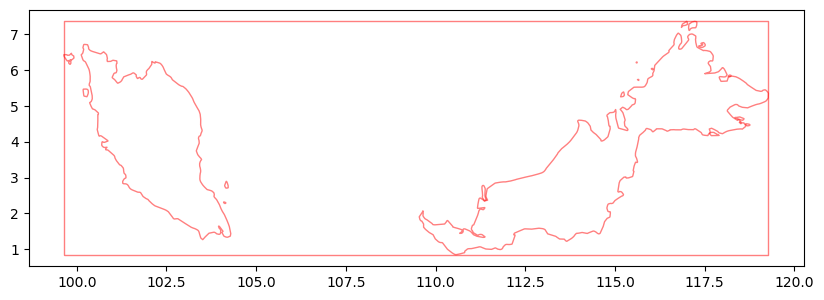

In [6]:
world_borders = gpd.read_file('../Ancillary_Datasets/TM_WORLD_BORDERS-0.2/TM_WORLD_BORDERS-0.2.shp')
mal = world_borders.loc[world_borders.NAME == 'Malaysia']
aoi_wkt = mal.envelope.geometry.values[0].wkt
print(aoi_wkt)

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
mal.envelope.plot(facecolor='', edgecolor='r', ax=ax, alpha=0.5);
mal.plot(facecolor='', edgecolor='r', ax=ax, alpha=0.5);

In [7]:
# Query ESA Open Access Hub
# print(esa_user,esa_pwd)
esa_api = SentinelAPI(esa_user,esa_pwd)
base = '../Malaysia/'
aoi = 'malaysia'

In [8]:
sensor = 's1'
src = 'esa'
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='SLC',sensoroperationalmode='IW')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'slc', src))
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'grd', src))

Querying products: 100%|██████████| 6738/6738 [03:55<00:00, 14.33 products/s]


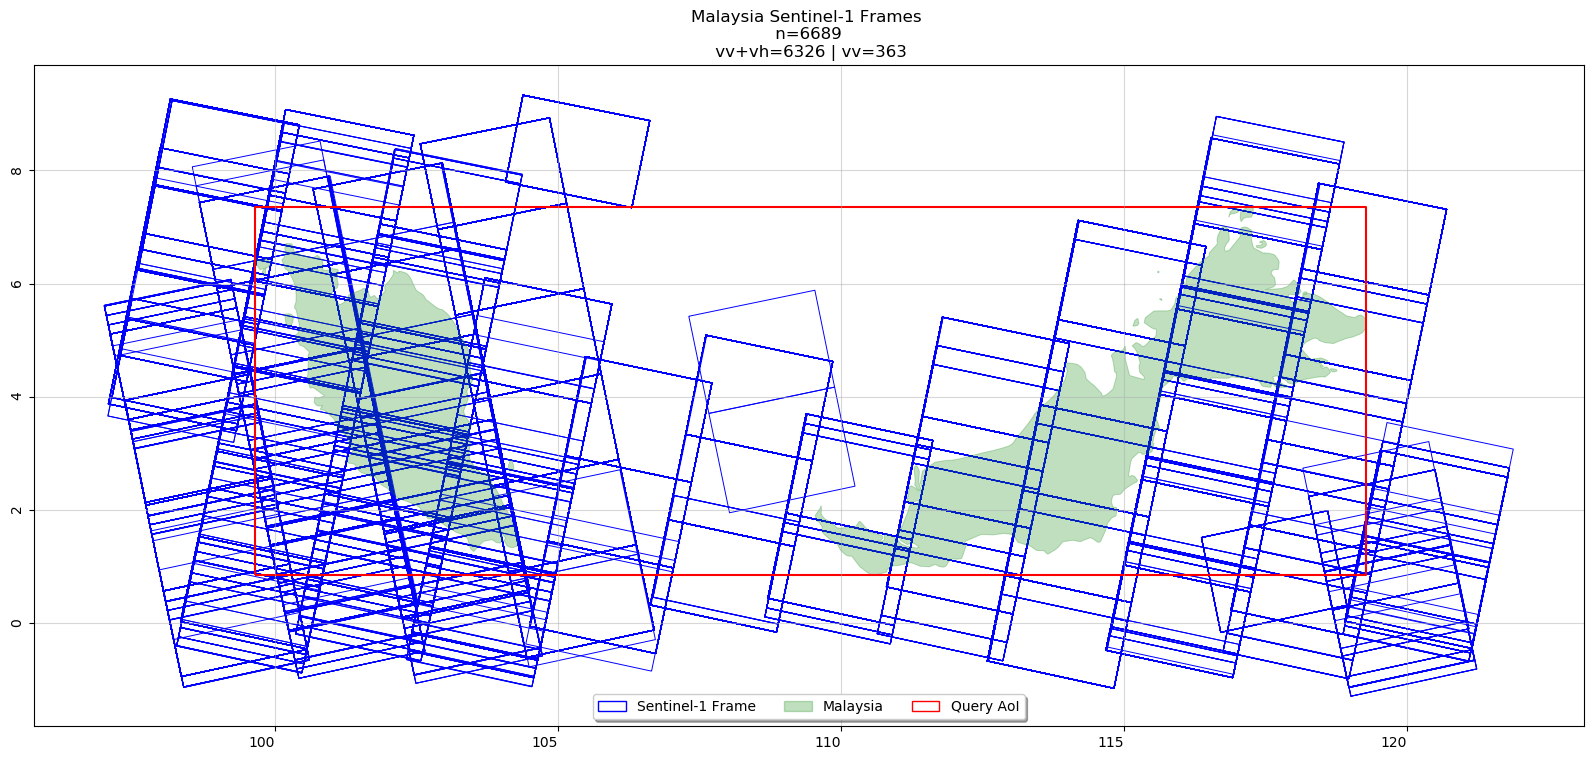

In [32]:
fig, ax = plt.subplots(figsize=(20,10),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

# # S2
# df = pd.read_csv(search_outputs_dir + 'fiji_overall_s2_l1c_esa.csv')
# df['s2platform'] = df['identifier'].str[:3]
# df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# # df = df[(df['Acquisition Date']>pd.Timestamp("2017-01-01", tz='utc')) & (df['Acquisition Date']<pd.Timestamp("2020-1-1", tz='utc'))]
# df['geometry'] = df['geometry'].apply(wkt.loads)
# df['geometry'] = df['geometry'].apply(lambda x: reproject_wkt_4326_3460(str(x)))
# df['geometry'] = df['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=('epsg:3460'))
# gdf.plot(facecolor="none", edgecolor='g', lw=0.7, ax=ax, alpha=0.5)
# leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='g', label='Sentinel-2', alpha=0.5))

# S1 = SAME IN ANY SCENARIO
df = pd.read_csv(base + 'malaysia_s1_grd_esa.csv')
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# df = df[(df['Acquisition Date']>pd.Timestamp("2017-01-01", tz='utc')) & (df['Acquisition Date']<pd.Timestamp("2020-1-1", tz='utc'))]
df['geometry'] = df['geometry'].apply(wkt.loads)
pols = df.groupby('polarisationmode')['uuid'].nunique()

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=('epsg:4326'))
gdf.plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='b', label='Sentinel-1 Frame'))

# WORLD BORDERS
mal.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Malaysia'))

# SCENARIO AOI
mal.envelope.plot(facecolor="none", edgecolor='r', lw=1.5, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='Query AoI'))

ax.set_title('Malaysia Sentinel-1 Frames \n n={} \n vv+vh={} | vv={}'.format(df.shape[0], pols[1], pols[0]))
ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

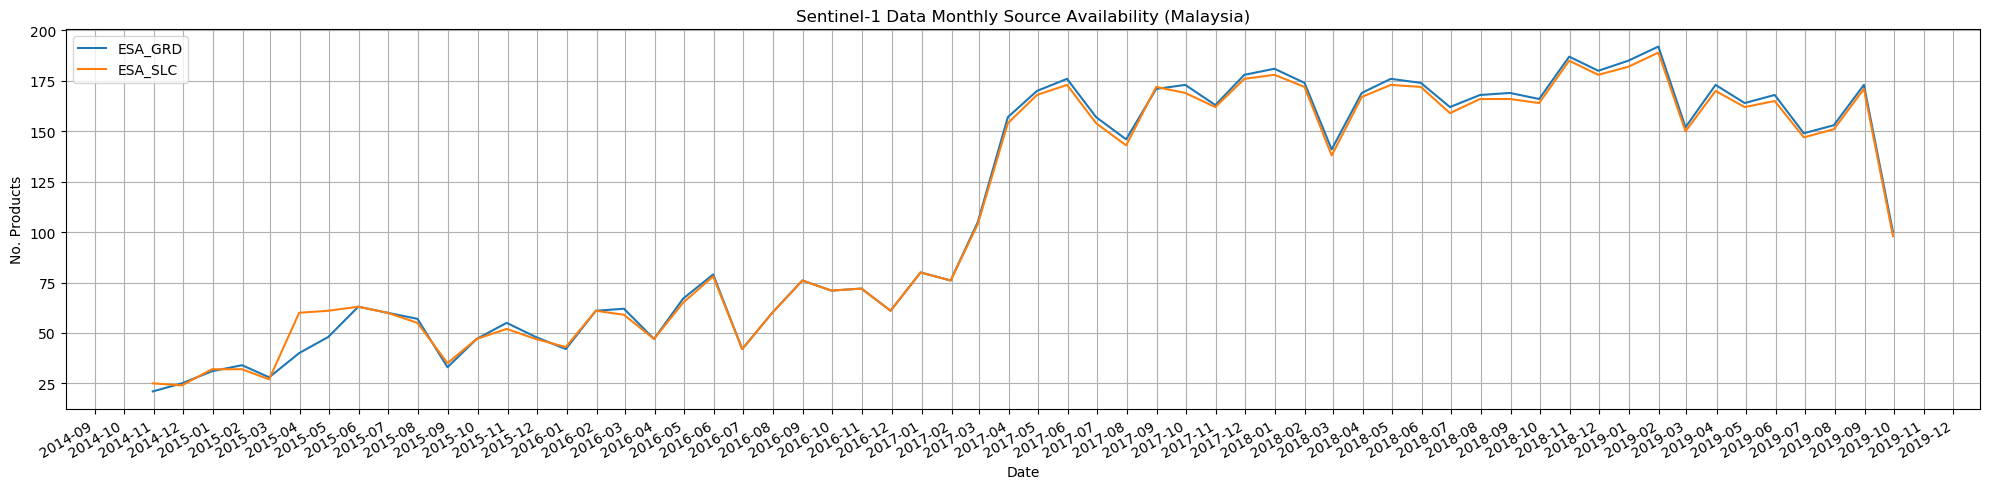

In [28]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=100)
fig.autofmt_xdate()

df = pd.read_csv(base + 'malaysia_s1_slc_esa.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv(base + 'malaysia_s1_grd_esa.csv')
#print('ESA SLC \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

#'bD-.'
ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_GRD','ESA_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-1 Data Monthly Source Availability (Malaysia)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();
# fig.savefig('../Search_Discovery/Fiji_S1_Monthly_Source_Availability');

In [30]:
df = pd.read_csv(base + 'malaysia_s1_grd_esa.csv')
s1_tot = len(df)
print('TOTAL SENTINEL-1 \n', 'No. Prods: ', len(df))
print(' Rough storage est.: ', (s1_tot * 1500)/1000000, 'TB' ,' # est avg filesize 1500 MB') 

TOTAL SENTINEL-1 
 No. Prods:  6689
 Rough storage est.:  10.0335 TB  # est avg filesize 1500 MB
